# Лекция №11

## На прошлой лекции

[Конвекция OpenFOAM](#convection_of)

[Нелинейность](#nonlinear)

## План
1. [Нелинейный источник. ODE](#ODE)
2. [Граничные условия](#bc)
3. [Уравнения Эйлера. rhoCentralFoam](#Euler)

## Нелинейный источник <a name="ODE"></a>

[Лобанов Обыкновенные дифференциальные уравнения](https://www.youtube.com/watch?v=_Y6Jv91GCnE&list=PLi-CH8_k35-NsXIqZ_yUoJKMClR3tXsky&index=13&t=2s)

$$
\int_V {\partial{\rho \phi}\over {\partial t}} dV + \int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV = \int_V \nabla \cdot \left(\Gamma \nabla \phi \right) dV + \int_V S_\phi dV
$$

Источник:
$$\int_V S_\phi dV \approx S_{\phi P} V_P$$

Источник - только объемные поля (volScalarField), нет связи с соседними ячейками

Смысл - производство (убыль)

$S = const$ - просто

$S = f(\phi)$ - умеем

$S = f(\phi, t)$ - сложнее

$S = f(\phi, t, \frac{\partial}{\partial t} )$ - это вообще законно? (ОДУ)

Случается, что в течениях с химическими реакциями и турбулентностью, источниковый член  $S$- много больше
остальных. Время изменения источникового члена много меньше характерного времени течения  $\frac{\Delta
t_{\mathit{flow}}}{\Delta t_{\mathit{source}}}\rightarrow \infty $.

Увеличивается жесткость системы — отношение максимального к минимальному значений собственных векторов 
$\frac{\lambda _{\mathit{max}}}{\lambda _{\mathit{min}}}$ или отношение максимального к минимальному характерных
масштабов времени.

Использование многошаговых явных схем к жестким системам — смягчает условие на шаг по времени, однако установление
происходит медленнее. Некоторые решения не дают корректного результата.

[ODE OpenFOAM](../books/ode_of.pdf)

[ODE OpenFOAM solvers doxygen](https://www.openfoam.com/documentation/guides/latest/api/group__grpODESolvers.html)

In [ ]:
#!cat ODE/Test-ODE.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2016 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Description

\*---------------------------------------------------------------------------*/

#include "argList.H"
#include "IOmanip.H"
#include "ODESystem.H"
#include "ODESolver.H"

using namespace Foam;

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

class testODE
:
    public ODESystem
{

public:

    testODE()
    {}

    label nEqns() const
    {
        return 4;
    }

    void derivatives
    (
        const scalar x,
        const scalarField& y,
        scalarField& dydx
    ) const
    {
        dydx[0] = -y[1];
        dydx[1] = y[0] - (1.0/x)*y[1];
        dydx[2] = y[1] - (2.0/x)*y[2];
        dydx[3] = y[2] - (3.0/x)*y[3];
    }

    void jacobian
    (
        const scalar x,
        const scalarField& y,
        scalarField& dfdx,
        scalarSquareMatrix& dfdy
    ) const
    {
        dfdx[0] = 0.0;
        dfdx[1] = (1.0/sqr(x))*y[1];
        dfdx[2] = (2.0/sqr(x))*y[2];
        dfdx[3] = (3.0/sqr(x))*y[3];

        dfdy(0, 0) = 0.0;
        dfdy(0, 1) = -1.0;
        dfdy(0, 2) = 0.0;
        dfdy(0, 3) = 0.0;

        dfdy(1, 0) = 1.0;
        dfdy(1, 1) = -1.0/x;
        dfdy(1, 2) = 0.0;
        dfdy(1, 3) = 0.0;

        dfdy(2, 0) = 0.0;
        dfdy(2, 1) = 1.0;
        dfdy(2, 2) = -2.0/x;
        dfdy(2, 3) = 0.0;

        dfdy(3, 0) = 0.0;
        dfdy(3, 1) = 0.0;
        dfdy(3, 2) = 1.0;
        dfdy(3, 3) = -3.0/x;
    }
};


// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
// Main program:

int main(int argc, char *argv[])
{
    argList::addArgument("ODESolver");
    argList args(argc, argv);

    // Create the ODE system
    testODE ode;

    dictionary dict;
    dict.add("solver", args[1]);

    // Create the selected ODE system solver
    autoPtr<ODESolver> odeSolver = ODESolver::New(ode, dict);

    // Initialise the ODE system fields
    scalar xStart = 1.0;
    scalarField yStart(ode.nEqns());
    yStart[0] = ::Foam::j0(xStart);
    yStart[1] = ::Foam::j1(xStart);
    yStart[2] = ::Foam::jn(2, xStart);
    yStart[3] = ::Foam::jn(3, xStart);

    // Print the evolution of the solution and the time-step
    scalarField dyStart(ode.nEqns());
    ode.derivatives(xStart, yStart, dyStart);

    Info<< setw(10) << "relTol" << setw(12) << "dxEst";
    Info<< setw(13) << "dxDid" << setw(14) << "dxNext" << endl;
    Info<< setprecision(6);

    for (label i=0; i<15; i++)
    {
        scalar relTol = ::Foam::exp(-scalar(i + 1));

        scalar x = xStart;
        scalarField y(yStart);

        scalar dxEst = 0.6;
        scalar dxNext = dxEst;

        odeSolver->relTol() = relTol;
        odeSolver->solve(x, y, dxNext);

        Info<< scientific << setw(13) << relTol;
        Info<< fixed << setw(11) << dxEst;
        Info<< setw(13) << x - xStart << setw(13) << dxNext
            << setw(13) << y[0] << setw(13) << y[1]
            << setw(13) << y[2] << setw(13) << y[3]
            << endl;
    }

    scalar x = xStart;
    scalar xEnd = x + 1.0;
    scalarField y(yStart);

    scalarField yEnd(ode.nEqns());
    yEnd[0] = ::Foam::j0(xEnd);
    yEnd[1] = ::Foam::j1(xEnd);
    yEnd[2] = ::Foam::jn(2, xEnd);
    yEnd[3] = ::Foam::jn(3, xEnd);

    scalar dxEst = 0.5;

    odeSolver->relTol() = 1e-4;
    odeSolver->solve(x, xEnd, y, dxEst);

    Info<< nl << "Analytical: y(2.0) = " << yEnd << endl;
    Info      << "Numerical:  y(2.0) = " << y << ", dxEst = " << dxEst << endl;

    Info<< "\nEnd\n" << endl;

    return 0;
}
```

In [1]:
!wmake ODE

wmake ODE


In [2]:
!Test-ODE -help


Usage: Test-ODE [OPTIONS] <ODESolver>
Options:
  -case <dir>       Specify case directory to use (instead of cwd)
  -decomposeParDict <file>
                    Use specified file for decomposePar dictionary
  -parallel         Run in parallel
  -doc              Display documentation in browser
  -help             Display short help and exit
  -help-full        Display full help and exit

Using: OpenFOAM-v2012 (2012) - visit www.openfoam.com
Build: _7bdb509494-20201222
Arch:  LSB;label=32;scalar=64



In [3]:
!Test-ODE banana

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : _7bdb509494-20201222 OPENFOAM=2012
Arch   : "LSB;label=32;scalar=64"
Exec   : Test-ODE banana
Date   : Dec 05 2021
Time   : 15:10:40
Host   : kuvv-PS63-Modern-8M
PID    : 14533
I/O    : uncollated
Case   : /home/kuvv/work/Projects/phystech_lectures/lecture_11
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModif

In [4]:
!Test-ODE Euler

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : _7bdb509494-20201222 OPENFOAM=2012
Arch   : "LSB;label=32;scalar=64"
Exec   : Test-ODE Euler
Date   : Dec 05 2021
Time   : 15:10:56
Host   : kuvv-PS63-Modern-8M
PID    : 14619
I/O    : uncollated
Case   : /home/kuvv/work/Projects/phystech_lectures/lecture_11
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModifi

In [5]:
!Test-ODE Rosenbrock12

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : _7bdb509494-20201222 OPENFOAM=2012
Arch   : "LSB;label=32;scalar=64"
Exec   : Test-ODE Rosenbrock12
Date   : Dec 05 2021
Time   : 15:11:15
Host   : kuvv-PS63-Modern-8M
PID    : 14703
I/O    : uncollated
Case   : /home/kuvv/work/Projects/phystech_lectures/lecture_11
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fil

In [6]:
!Test-ODE Rosenbrock34

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : _7bdb509494-20201222 OPENFOAM=2012
Arch   : "LSB;label=32;scalar=64"
Exec   : Test-ODE Rosenbrock34
Date   : Dec 05 2021
Time   : 15:11:37
Host   : kuvv-PS63-Modern-8M
PID    : 14829
I/O    : uncollated
Case   : /home/kuvv/work/Projects/phystech_lectures/lecture_11
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fil

## Граничные условия  <a name="bc"></a> 

<img src="img/finite_volume.png" width="800" height="200">


У любой области есть границы. У граничных ячеек нет соседа - должны обрабатываться отдельно от общего алгоритма!

Определяются постановкой задачи. Для Гиперболических уравнений существуют характеристики!

[Решение уравнения переноса](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-divergence-example.html)

[Boundary conditions OpenFOAM doxygen](https://www.openfoam.com/documentation/guides/latest/doc/openfoam-guide-boundary-conditions.html)

[Source documentation](https://www.openfoam.com/documentation/guides/latest/api/group__grpBoundaryConditions.html)

## Система линейных дифференциальных уравнений гиперболического типа.  <a name="PDE"></a> 

Система дифференциальных уравнений:

$${\partial{\vec u}\over {\partial t}}+{\partial{\vec f(\vec u)}\over {\partial x}}=0$$

$${\partial{\vec u}\over {\partial t}}+A(\vec u){\partial{\vec u}\over {\partial x}}=0$$

$\vec u$ - вектор cтолбец незвестных размерности $N$

$\vec f$ - вектор потоков размерности $N$

$A$ - матрица Якоби (Якобиан)

Система является гиперболической, если все собственные значения матрицы $A$ действительны.

Для одного уравнения была одна характеристика.

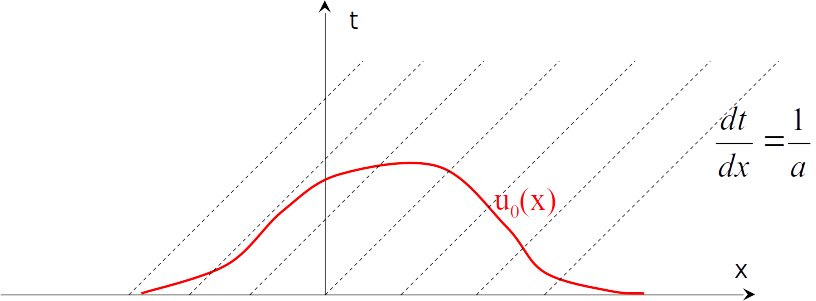

Теперь $N$ характеристик (по размерности системы) выходит из каждой точки пространства!

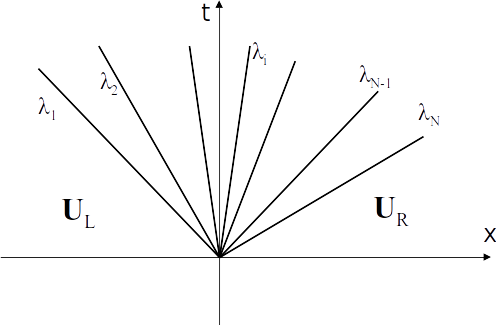

Для линейной системы: переходим к новым переменным

Находим собственные значения $\Lambda$ (диагональная матрица), матрицы правых $R$ и левых собственных векторов и представляем матрицу $A$ в виде:
$A = R \Lambda L$

Домножаем на L слева систему, получаем: $$L{\partial{\vec u}\over {\partial t}}+LR \Lambda L{\partial{\vec u}\over {\partial x}}=0$$

Помним, что $LR = E$, обозначаем за новые переменные $\vec w = L \vec u$, получаем:

$${\partial{\vec w}\over {\partial t}}+\Lambda {\partial{\vec w}\over {\partial x}}=0$$

$\Lambda$ - диагональная матрица из собственных значений матрицы $A$

$N$ независимых уравнений!

$w_i$ компонента вектора переносится неизменно вдоль $\lambda_i$ характеристики

$w_i$ - линейная комбинация из компонент вектора $\vec u$

## Система уравнений Эйлера. rhoCentralFoam  <a name="Euler"></a> 

Система уравнений Эйлера для одномерной газовой динамики:

$${{ \partial \rho}  \over  { \partial t} } + {  { \partial (\rho U )}  \over  { \partial x} } =0 \\
{{ \partial \rho U}  \over  { \partial t} } + {  { \partial (\rho U^2 + p )}  \over  { \partial x} } =0 \\
{{ \partial E}  \over  { \partial t} } + {  { \partial (\rho U H )}  \over  { \partial x} } =0 \\
E = \rho (e + U^2/2) \\
H = (E+p)/\rho
$$

$$
\vec u = \begin{bmatrix} \rho \\ \rho U  \\ E \end{bmatrix} , \vec f = \begin{bmatrix} \rho U \\ \rho U^2+p  \\ \rho U H \end{bmatrix}
$$

для уравнения состояния вида $p = p(\rho, e)$

$$ A = \frac{\partial \vec f}{\partial \vec u} =  \begin{bmatrix} 0 & 1 & 0 \\
P_\rho+\psi(U^2 - E/\rho) - U^2 & U(2-\psi) & \psi\\
(P_rho + \psi(U^2 - E/\rho) - H)U & H-\psi U^2 & U(1+\psi)
\end{bmatrix}\\
\psi = P_e/\rho \\
\lambda_{1-3} = U-a, U, U+a$$ 

In [5]:
# rhoCentralFoam (compressible solver)
!ls $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/

Allwclean  centralCourantNo.H  directionInterpolate.H  rhoCentralDyMFoam
Allwmake   createFieldRefs.H   Make		       rhoCentralFoam.C
BCs	   createFields.H      readFluxScheme.H        setRDeltaT.H


In [4]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/rhoCentralFoam.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2016 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Application
    rhoCentralFoam

Group
    grpCompressibleSolvers

Description
    Density-based compressible flow solver based on central-upwind
    schemes of Kurganov and Tadmor.

\*---------------------------------------------------------------------------*/

#include "fvCFD.H"
#include "psiThermo.H"
#include "turbulentFluidThermoModel.H"
#include "fixedRhoFvPatchScalarField.H"
#include "directionInterpolate.H"
#include "localEulerDdtScheme.H"
#include "fvcSmooth.H"

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

int main(int argc, char *argv[])
{
    argList::addNote
    (
        "Density-based compressible flow solver based on central-upwind"
        " schemes of Kurganov and Tadmor."
    );

    #define NO_CONTROL
    #include "postProcess.H"

    #include "addCheckCaseOptions.H"
    #include "setRootCaseLists.H"
    #include "createTime.H"
    #include "createMesh.H"
    #include "createFields.H"
    #include "createFieldRefs.H"
    #include "createTimeControls.H"

    turbulence->validate();

    // * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

    #include "readFluxScheme.H"

    const dimensionedScalar v_zero(dimVolume/dimTime, Zero);

    // Courant numbers used to adjust the time-step
    scalar CoNum = 0.0;
    scalar meanCoNum = 0.0;

    Info<< "\nStarting time loop\n" << endl;

    while (runTime.run())
    {
        // --- Directed interpolation of primitive fields onto faces

        surfaceScalarField rho_pos(interpolate(rho, pos));
        surfaceScalarField rho_neg(interpolate(rho, neg));

        surfaceVectorField rhoU_pos(interpolate(rhoU, pos, U.name()));
        surfaceVectorField rhoU_neg(interpolate(rhoU, neg, U.name()));

        volScalarField rPsi("rPsi", 1.0/psi);
        surfaceScalarField rPsi_pos(interpolate(rPsi, pos, T.name()));
        surfaceScalarField rPsi_neg(interpolate(rPsi, neg, T.name()));

        surfaceScalarField e_pos(interpolate(e, pos, T.name()));
        surfaceScalarField e_neg(interpolate(e, neg, T.name()));

        surfaceVectorField U_pos("U_pos", rhoU_pos/rho_pos);
        surfaceVectorField U_neg("U_neg", rhoU_neg/rho_neg);

        surfaceScalarField p_pos("p_pos", rho_pos*rPsi_pos);
        surfaceScalarField p_neg("p_neg", rho_neg*rPsi_neg);

        surfaceScalarField phiv_pos("phiv_pos", U_pos & mesh.Sf());
        // Note: extracted out the orientation so becomes unoriented
        phiv_pos.setOriented(false);
        surfaceScalarField phiv_neg("phiv_neg", U_neg & mesh.Sf());
        phiv_neg.setOriented(false);

        volScalarField c("c", sqrt(thermo.Cp()/thermo.Cv()*rPsi));
        surfaceScalarField cSf_pos
        (
            "cSf_pos",
            interpolate(c, pos, T.name())*mesh.magSf()
        );

        surfaceScalarField cSf_neg
        (
            "cSf_neg",
            interpolate(c, neg, T.name())*mesh.magSf()
        );

        surfaceScalarField ap
        (
            "ap",
            max(max(phiv_pos + cSf_pos, phiv_neg + cSf_neg), v_zero)
        );

        surfaceScalarField am
        (
            "am",
            min(min(phiv_pos - cSf_pos, phiv_neg - cSf_neg), v_zero)
        );

        surfaceScalarField a_pos("a_pos", ap/(ap - am));

        surfaceScalarField amaxSf("amaxSf", max(mag(am), mag(ap)));

        surfaceScalarField aSf("aSf", am*a_pos);

        if (fluxScheme == "Tadmor")
        {
            aSf = -0.5*amaxSf;
            a_pos = 0.5;
        }

        surfaceScalarField a_neg("a_neg", 1.0 - a_pos);

        phiv_pos *= a_pos;
        phiv_neg *= a_neg;

        surfaceScalarField aphiv_pos("aphiv_pos", phiv_pos - aSf);
        surfaceScalarField aphiv_neg("aphiv_neg", phiv_neg + aSf);

        // Reuse amaxSf for the maximum positive and negative fluxes
        // estimated by the central scheme
        amaxSf = max(mag(aphiv_pos), mag(aphiv_neg));

        #include "centralCourantNo.H"
        #include "readTimeControls.H"

        if (LTS)
        {
            #include "setRDeltaT.H"
        }
        else
        {
            #include "setDeltaT.H"
        }

        ++runTime;

        Info<< "Time = " << runTime.timeName() << nl << endl;

        phi = aphiv_pos*rho_pos + aphiv_neg*rho_neg;

        surfaceVectorField phiU(aphiv_pos*rhoU_pos + aphiv_neg*rhoU_neg);
        // Note: reassembled orientation from the pos and neg parts so becomes
        // oriented
        phiU.setOriented(true);

        surfaceVectorField phiUp(phiU + (a_pos*p_pos + a_neg*p_neg)*mesh.Sf());

        surfaceScalarField phiEp
        (
            "phiEp",
            aphiv_pos*(rho_pos*(e_pos + 0.5*magSqr(U_pos)) + p_pos)
          + aphiv_neg*(rho_neg*(e_neg + 0.5*magSqr(U_neg)) + p_neg)
          + aSf*p_pos - aSf*p_neg
        );

        volScalarField muEff("muEff", turbulence->muEff());
        volTensorField tauMC("tauMC", muEff*dev2(Foam::T(fvc::grad(U))));

        // --- Solve density
        solve(fvm::ddt(rho) + fvc::div(phi));

        // --- Solve momentum
        solve(fvm::ddt(rhoU) + fvc::div(phiUp));

        U.ref() =
            rhoU()
           /rho();
        U.correctBoundaryConditions();
        rhoU.boundaryFieldRef() == rho.boundaryField()*U.boundaryField();

        if (!inviscid)
        {
            solve
            (
                fvm::ddt(rho, U) - fvc::ddt(rho, U)
              - fvm::laplacian(muEff, U)
              - fvc::div(tauMC)
            );
            rhoU = rho*U;
        }

        // --- Solve energy
        surfaceScalarField sigmaDotU
        (
            "sigmaDotU",
            (
                fvc::interpolate(muEff)*mesh.magSf()*fvc::snGrad(U)
              + fvc::dotInterpolate(mesh.Sf(), tauMC)
            )
          & (a_pos*U_pos + a_neg*U_neg)
        );

        solve
        (
            fvm::ddt(rhoE)
          + fvc::div(phiEp)
          - fvc::div(sigmaDotU)
        );

        e = rhoE/rho - 0.5*magSqr(U);
        e.correctBoundaryConditions();
        thermo.correct();
        rhoE.boundaryFieldRef() ==
            rho.boundaryField()*
            (
                e.boundaryField() + 0.5*magSqr(U.boundaryField())
            );

        if (!inviscid)
        {
            solve
            (
                fvm::ddt(rho, e) - fvc::ddt(rho, e)
              - fvm::laplacian(turbulence->alphaEff(), e)
            );
            thermo.correct();
            rhoE = rho*(e + 0.5*magSqr(U));
        }

        p.ref() =
            rho()
           /psi();
        p.correctBoundaryConditions();
        rho.boundaryFieldRef() == psi.boundaryField()*p.boundaryField();

        turbulence->correct();

        runTime.write();

        runTime.printExecutionTime(Info);
    }

    Info<< "End\n" << endl;

    return 0;
}

// ************************************************************************* //
```

In [7]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/createFields.H

[createRDeltaT.H doxygen](https://www.openfoam.com/documentation/guides/latest/api/createRDeltaT_8H_source.html)

```c++
#include "createRDeltaT.H"

Info<< "Reading thermophysical properties\n" << endl;

autoPtr<psiThermo> pThermo
(
    psiThermo::New(mesh)
);
psiThermo& thermo = pThermo();

volScalarField& e = thermo.he();

Info<< "Reading field U\n" << endl;
volVectorField U
(
    IOobject
    (
        "U",
        runTime.timeName(),
        mesh,
        IOobject::MUST_READ,
        IOobject::AUTO_WRITE
    ),
    mesh
);

volScalarField rho
(
    IOobject
    (
        "rho",
        runTime.timeName(),
        mesh,
        IOobject::NO_READ,
        IOobject::AUTO_WRITE
    ),
    thermo.rho()
);

volVectorField rhoU
(
    IOobject
    (
        "rhoU",
        runTime.timeName(),
        mesh,
        IOobject::NO_READ,
        IOobject::NO_WRITE
    ),
    rho*U
);

volScalarField rhoE
(
    IOobject
    (
        "rhoE",
        runTime.timeName(),
        mesh,
        IOobject::NO_READ,
        IOobject::NO_WRITE
    ),
    rho*(e + 0.5*magSqr(U))
);

surfaceScalarField pos
(
    IOobject
    (
        "pos",
        runTime.timeName(),
        mesh
    ),
    mesh,
    dimensionedScalar("pos", dimless, 1.0)
);

surfaceScalarField neg
(
    IOobject
    (
        "neg",
        runTime.timeName(),
        mesh
    ),
    mesh,
    dimensionedScalar("neg", dimless, -1.0)
);

surfaceScalarField phi("phi", fvc::flux(rhoU));

Info<< "Creating turbulence model\n" << endl;
autoPtr<compressible::turbulenceModel> turbulence
(
    compressible::turbulenceModel::New
    (
        rho,
        U,
        phi,
        thermo
    )
);
```

In [9]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/createFieldRefs.H

```c++
volScalarField& p = thermo.p();
const volScalarField& T = thermo.T();
const volScalarField& psi = thermo.psi();
const volScalarField& mu = thermo.mu();

bool inviscid(true);
if (max(mu.primitiveField()) > 0.0)
{
    inviscid = false;
}
```

## Заключение

1. [Нелинейный источник. ODE](#ODE)
2. [Граничные условия](#bc)
3. [Уравнения Эйлера. rhoCentralFoam](#Euler)

## В следующей серии ...

Термодинамика, метод Годунова, задача Римана о распаде произвольного разрыва! 

<table><tr>
<td> <img src="img/thermo.jpg" width="500" height="200"> </td>
<td> <img src="img/godunov.jpg" width="500" height="200"> </td>
</tr></table>
